# Portfolio Optimization

***In this notebook, we take a look at a series of stocks and crypto currencies by graphing their risk/return chart, along with graphing their efficient frontiers and capital allocation lines tangent to the max sharpe portfolios.***

### Step 1) Import libraries and define ticker arrays

In [1]:
# Load all of the libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Create tickers lists

stocks = ['SPY','AAPL','AMZN','JPM','WMT','TSLA','HD','JNJ','QCOM','MSFT','GS','VZ']
crypto = ['BTC-USD','ETH-USD','DOGE-USD','LTC-USD','SHIB-USD','ADA-USD','LINK-USD','XLM-USD','ZEC-USD','ACH-USD']

### Step 2) Import the datasets from given tickers and print out one assets dataframe

In [2]:
# Import data into dictionaries

stock_data = {tick:pd.read_csv(f'datasets/{tick}.csv') for tick in stocks}
crypto_data = {tick:pd.read_csv(f'datasets/{tick}.csv') for tick in crypto}

print(crypto_data['BTC-USD'])

     Unnamed: 0                 Time       Low      High      Open     Close  \
0             0  02-17-2023 19:00:00  24407.67  24879.33  24577.60  24792.19   
1             1  02-16-2023 19:00:00  23344.12  25025.00  23516.95  24577.60   
2             2  02-15-2023 19:00:00  23510.73  25256.83  24326.95  23516.15   
3             3  02-14-2023 19:00:00  22054.17  24386.50  22206.26  24329.04   
4             4  02-13-2023 19:00:00  21545.67  22331.76  21789.00  22206.27   
..          ...                  ...       ...       ...       ...       ...   
294         294  04-29-2022 20:00:00  37590.00  38795.00  38592.27  37644.10   
295         295  04-28-2022 20:00:00  38161.85  39926.80  39741.21  38593.10   
296         296  04-27-2022 20:00:00  38883.83  40400.00  39251.02  39743.22   
297         297  04-26-2022 20:00:00  37882.83  39470.00  38118.43  39251.11   
298         298  04-25-2022 20:00:00  37700.00  40817.16  40440.90  38113.82   

           Volume  
0     4996.630235  

### Step 3) Extract dates from datasets dictionaries

In [3]:
# Pull dates from pandas framea and print them out to get a look at their format

dateA, dateB = stock_data['AAPL']['date'].values.tolist(), crypto_data['BTC-USD']['Time'].values.tolist()

print(dateA[0], dateB[0])

2023-02-17 02-17-2023 19:00:00


### Step 4) Arrange dates to exclude weekends in order for accurate comparison

In [4]:
def align_set(dA, dB):
    
    # Convert time shown above to a rearranged date
    def convert_crypto_time(x):
        x = x.split(' ')[0]
        x = x.split('-')
        return f'{x[-1]}-{x[0]}-{x[1]}'
    
    # Convert all crypto dates to match stock dates format
    dB = list(map(convert_crypto_time, dB))
    
    # Create a variable called hold to store stock and crypto row indexes
    hold = []
    for i, j in enumerate(dB):
        if j in dA:
            # x value = stock index, y value is crypto index
            hold.append([dA.index(j), i])
            
    return hold

align = align_set(dateA, dateB)

### Step 5) Build a set of close prices for stocks, crypto, and both

In [5]:
# Uses the previously calculated indecies in order to align stocks and crypto data

Limit = 31+20 # Set lookback period limit

def align_data(align, Stocks, Cryptos):
    holdA = []
    holdB = []
    holdC = []
    
    for x, y in align[:Limit+1]:
        tA = []
        tB = []
        tC = []
        for a in stocks:
            tA.append(Stocks[a]['adjClose'].values.tolist()[x])
            tC.append(Stocks[a]['adjClose'].values.tolist()[x])
        for a in crypto:
            tB.append(Cryptos[a]['Close'].values.tolist()[y])
            tC.append(Cryptos[a]['Close'].values.tolist()[y])
        holdA.append(tA)
        holdB.append(tB)
        holdC.append(tC)
    
    return [np.array(c) for c in (holdA, holdB, holdC)]

# Calculates rate of return
ror = lambda i: i[:-1]/i[1:] - 1

# Fetch aligned close prices
close_stock, close_crypto, close_both = align_data(align, stock_data, crypto_data)

# Calculate rate of returns
ror_stock, ror_crypto, ror_both = ror(close_stock), ror(close_crypto), ror(close_both)


### Step 6) Calculate the mean, standard deviation, and covariance matrix
<br/>
<br/>

<center>$ \Large \mu = \dfrac{1}{m}1^Tx $</center>
<br/>
<br/>
<center>$ \Large \Sigma = \dfrac{1}{m - 1} (X - \hat{X})^T(X - \hat{X}) $</center>

<br/>
<br/>
<center>$ \Large \sigma = \sqrt{diag(\Sigma)} $</center>

In [6]:
# Calculates mean vector, standard deviation vector, and covariance matrix
def musd(x):
    m, n = x.shape
    mu = (1/m)*np.ones(m).dot(x)
    cv = (1/(m-1))*(x - mu).T.dot(x - mu)
    sd = np.sqrt(np.diag(cv))
    return sd, mu, cv

s_stock = musd(ror_stock)
s_crypto = musd(ror_crypto)
s_both = musd(ror_both)

### Step 7) Plot the risk return data with annotated tickers just to see if this works so far

Text(0.5, 1.0, 'Stocks Risk/Return')

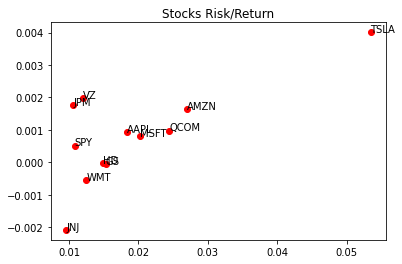

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(s_stock[0], s_stock[1], color='red', label='Stocks')

for t, x, y in zip(stocks, s_stock[0], s_stock[1]):
    ax.annotate(t, xy=(x, y))
    
ax.set_title('Stocks Risk/Return')

### Step 8) Do the same with the crypto data in a seperate plot

Text(0.5, 1.0, 'Crypto Risk/Return')

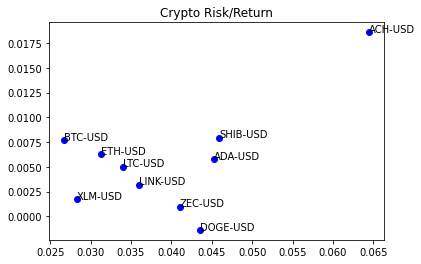

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(s_crypto[0], s_crypto[1], color='blue', label='Cryptos')

for t, x, y in zip(crypto, s_crypto[0], s_crypto[1]):
    ax.annotate(t, xy=(x, y))
    
ax.set_title('Crypto Risk/Return')

### Step 9) Calculate the efficient frontier weights
<br/>
<br/>
<center>$ \Large \begin{bmatrix}2\Sigma&\mu&1\\\mu^T&0&0\\1^T&0&0 \end{bmatrix}^{-1} \begin{bmatrix} 0\\r_t\\1 \end{bmatrix} = \begin{bmatrix} w\\\lambda_1\\\lambda_2 \end{bmatrix}$</center>

In [9]:
# Uses the matrix function pictured above to generate a set of optimal weights for an inputted target return
def optimize(x, r):
    sd, mu, cv = musd(x)
    cov = (2.0*cv).tolist()
    n = len(cov)
    for i in range(n):
        cov[i].append(mu[i])
        cov[i].append(1.0)
    cov.append(mu.tolist() + [0, 0])
    cov.append(np.ones(n).tolist() + [0, 0])
    z = np.array(cov)
    b = np.array([[0] for i in range(n)] + [[r],[1]])
    return np.linalg.inv(z).dot(b)[:-2]

# Collects weights by looping through the inputted rates and returns you an efficient frontier curve
def efficient_frontier(x, mu, cov, m=20):
    m0, m1 = np.min(mu), np.max(mu)
    dM = (m1 - m0)/(m - 1)
    ux, uy = [], []
    for rate in range(m):
        rs = m0 + rate*dM
        w = optimize(x, rs)
        risk = np.sqrt(w.T.dot(cov.dot(w))[0][0])
        retn = w.T.dot(mu)[0]
        ux.append(risk)
        uy.append(retn)
    return ux, uy

### Step 10) Use the efficient frontier function on the three rates of return variables and plot it all in a single graph

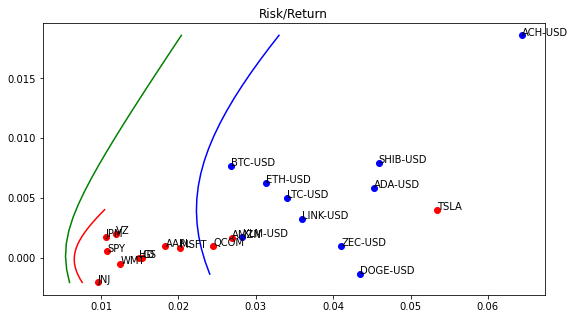

In [10]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

def graphIt(ax):
    sx, sy = efficient_frontier(ror_stock, s_stock[1], s_stock[2])
    cx, cy = efficient_frontier(ror_crypto, s_crypto[1], s_crypto[2])
    bx, by = efficient_frontier(ror_both, s_both[1], s_both[2])
    
    ax.scatter(s_stock[0], s_stock[1], color='red', label='Stocks')

    for t, x, y in zip(stocks, s_stock[0], s_stock[1]):
        ax.annotate(t, xy=(x, y))

    ax.set_title('Risk/Return')

    ax.scatter(s_crypto[0], s_crypto[1], color='blue', label='Cryptos')

    for t, x, y in zip(crypto, s_crypto[0], s_crypto[1]):
        ax.annotate(t, xy=(x, y))


    ax.plot(sx, sy, color='red')
    ax.plot(cx, cy, color='blue')
    ax.plot(bx, by, color='green')
    
graphIt(ax)

### Step 11) Graph the capital allocation line to the three tangent portfolios

<br/>
<br/>

##### 1. Generate a set of weights w = (0%, 100%, 200%)
##### 2. Calculate your x and y values by multiplying the weights by the optimal tangency risk/return points

<br/>
<br/>
<center>$ \Large x_i = w_i\sigma_i $</center>
<br/>
<center>$ \Large y_i = w_i\mu_i + (1 - w_i)(-\mu_i)$</center>

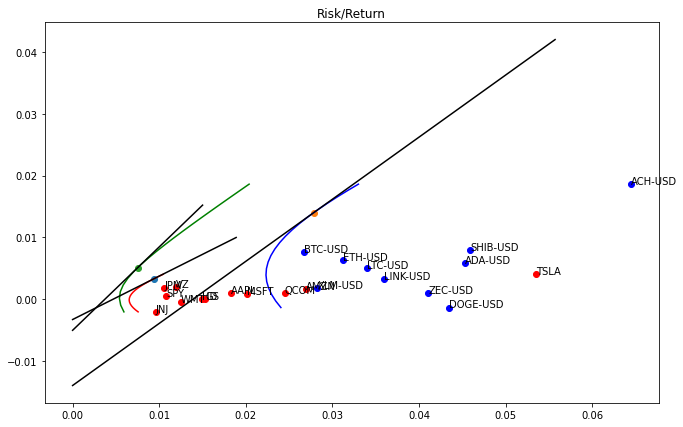

In [11]:
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)

def graphIt2(ax):
    # Create tangent portfolio weights with scipy's optimizer

    def max_sharpe(mu, cov):
        def objective(x):
            return -(x.T.dot(mu))/(x.T.dot(cov.dot(x)))
        def cons1(x):
            return np.sum(x) - 1
        cons = [{'type':'ineq','fun':cons1}]
        x = [0.01 for i in mu]
        res = minimize(objective, x, method='SLSQP', bounds=None, constraints=cons)
        return res.x

    # Calculate your sharpe weights
    sharpe_stocks = max_sharpe(s_stock[1], s_stock[2])
    sharpe_cryptos = max_sharpe(s_crypto[1], s_crypto[2])
    sharpe_both = max_sharpe(s_both[1], s_both[2])

    # Plot previous cell data
    graphIt(ax)

    # Capital allocation line weights
    cal = (0, 1, 2)

    for w, cov, mu in zip((sharpe_stocks, sharpe_cryptos, sharpe_both),(s_stock[-1], s_crypto[-1], s_both[-1]),(s_stock[1], s_crypto[1], s_both[1])):
        risky = np.sqrt(w.T.dot(cov.dot(w)))
        retz = w.T.dot(mu)
        ax.scatter(risky, retz)

        cal_x, cal_y = [], []
        for zz in cal:
            cal_x.append(zz*risky)
            cal_y.append(zz*retz + (1-zz)*-retz)

        ax.plot(cal_x, cal_y, color='black')
        

graphIt2(ax)     
        

### We are finished, hope you enjoyed reading my notebook and the abstract graphing!